In [11]:
conda install pytorch::pytorch torchvision torchaudio -c pytorch

78469.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
conda install matplotlib

78485.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install pytorch-lightning

78499.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [14]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import matplotlib.pyplot as plt
import pytorch_lightning as pl
torch.manual_seed(0)

In [15]:
pip install einops

78509.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [16]:
from einops.layers.torch import Reduce

In [17]:
!chmod u+rwx /Users/jeonghwan/Desktop/vit_practice/data

78549.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [18]:
training_data = datasets.MNIST(
    root="/Users/jeonghwan/Desktop/vit_practice/data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="/Users/jeonghwan/Desktop/vit_practice/data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

learning_rate = 1e-3
batch_size = 128
epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [19]:
import numpy as np

In [20]:
data, label = next(iter(train_dataloader))

In [21]:
data.shape #[batch_size, channel, width, height]

torch.Size([128, 1, 28, 28])

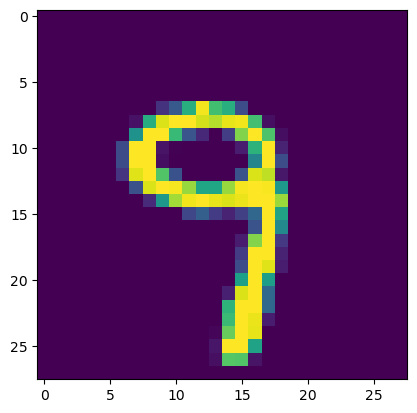

In [23]:
plt.imshow(data[0].reshape(28,28))

In [24]:
label

tensor([9, 3, 5, 4, 7, 4, 9, 6, 8, 8, 7, 4, 8, 9, 4, 0, 6, 8, 9, 9, 3, 1, 3, 2,
        5, 0, 2, 1, 6, 5, 5, 4, 7, 4, 1, 8, 7, 3, 3, 5, 1, 6, 0, 1, 4, 4, 0, 0,
        7, 0, 6, 7, 8, 9, 2, 1, 0, 7, 9, 2, 6, 8, 7, 7, 2, 8, 8, 5, 7, 1, 9, 3,
        1, 2, 4, 8, 6, 5, 1, 6, 5, 6, 8, 8, 5, 0, 2, 7, 2, 5, 8, 7, 7, 7, 2, 7,
        8, 8, 7, 7, 0, 2, 9, 5, 5, 4, 6, 6, 2, 3, 3, 1, 5, 5, 1, 8, 8, 7, 6, 2,
        0, 7, 3, 9, 2, 1, 4, 7])

In [25]:
data[0].shape

torch.Size([1, 28, 28])

In [30]:
# Patch Embedding 구현

project = nn.Conv2d(1, 16, kernel_size= 4, stride=4)
#in_chan = 1
#self.emb_size = Channel * Patch Size * Patch Size = 1 * 4 * 4 = 16
#Kernel Size = Patch Size 
#Stride = Patch Size
project(data[0].unsqueeze(0)).shape

torch.Size([1, 16, 7, 7])

In [31]:
# CLS token, Position Embedding 구현
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size,batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / pow(patch_size, 2)) # 49
        self.emb_size = in_chan * patch_size * patch_size # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
    
 
    def forward(self, x):
        x = self.project(x)
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #[batch_size, 1 , 16]
        x = torch.cat((repeat_cls, x), dim=1)
        x += self.positions
        return x

In [36]:
class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention

In [41]:
# Transformer, ViT encoder의 MLP 부분
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [38]:
class VIT(nn.Module):
    def __init__(self,emb_size = 16):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(1, 28*28, 4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        # Layer Normalization 사용
        self.norm = nn.LayerNorm(emb_size)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        
        norm_x = self.norm(x)
        multihead_output, attention = self.Multihead(norm_x)
        
        #residual Function
        output = multihead_output + x
        
        norm_output = self.norm(output)
        FFB = self.FFB(norm_output)
        
        final_out = FFB + output
        
        return final_out, attention

In [42]:
# 위에서 구현한 모델 여러 번 쌓아서 모델 완성시키기
class TransformerEncoder(nn.Module):
    def __init__(self, n_layers: 5, ):
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)
            
        return final_out

In [49]:
import torchmetrics
ac = torchmetrics.Accuracy(task="multiclass", num_classes = 10).to('mps')

In [98]:
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss = []
        self.Encoder = nn.Sequential(
            TransformerEncoder(n_layers = 5),
            #Reduce('b n e -> b e', reduction='mean')
        )
        self.final_layer = nn.Linear(16, 10)
        self.val_loss = []
        self.acc = []
        self.test_acc =[]
        
    def forward(self, x):
        x = self.Encoder(x)
        # 0번째 토큰만 뽑아서 클래스만큼 Layer를 구현
        cls_token_final = x[:,0]
        #(cls_token_final.shape)
        cls_token_final = self.final_layer(cls_token_final)
        return cls_token_final
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)

        self.loss.append(loss.item())
        return loss 
    
    def on_train_epoch_end(self):
        mean_loss = sum(self.loss) / 430
        print(f'traing_loss :{mean_loss}')
        self.loss = []
        self.acc = []
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        self.val_loss.append(loss.item())
        acc = ac(logits, y)
        self.acc.append(acc)
        return loss 
    
    def on_validation_epoch_end(self):
        mean_loss = sum(self.val_loss) / 40
        mean_acc = sum(self.acc)/ 40
        print(f'val loss :{mean_loss}, val_acc : {mean_acc}')

        self.val_loss = []
        self.acc = []
        self.log("val_loss", mean_loss)
        
    def test_dataloader(self):
        return test_dataloader
        
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = ac(logits, y)
        self.test_acc.append(acc)
        
    def on_test_epoch_end(self):
        mean_acc = sum(self.test_acc)/ 79
        print(mean_acc)


            
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)      

In [87]:
gpus = torch.backends.mps.is_available()
gpus = 1

In [88]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [89]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', mode ='min', patience=5)

In [90]:
model = VIT_Encoder()
k = model.test_dataloader()
b, y = next(iter(k))
print(y.shape)

torch.Size([128])


In [104]:
model = VIT_Encoder()
trainer = pl.Trainer(max_epochs=50, devices=1, callbacks=[early_stop_callback])
trainer.fit(model, train_dataloader, val_dataloaders = val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | Encoder     | Sequential | 25.8 K | train
1 | final_layer | Linear     | 170    | train
---------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 430/430 [00:26<00:00, 16.52it/s, v_num=6]


In [105]:
trainer.test()

Restoring states from the checkpoint path at /Users/jeonghwan/Desktop/vit practice/lightning_logs/version_6/checkpoints/epoch=0-step=430.ckpt
Loaded model weights from the checkpoint at /Users/jeonghwan/Desktop/vit practice/lightning_logs/version_6/checkpoints/epoch=0-step=430.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 32.60it/s]


[{}]